# Monte Carlo Ising Model

### Metropolis-Hastings algorithm

Instead of requiring us to calculate the partition function to evaluate probability, the *Metropolis-Hastings algorithm* allows us to compare **relative likelihoods** of the new and old configurations

For example, say we propose a randomly flipped spin. We can write expressions for the probability of each configuration
$$ P_{before} = \frac{e^{-\beta H_{before}}}{Z} \quad  P_{after} = \frac{e^{-\beta H_{after}}}{Z} $$

If we instead look at the relative likelihood, the difficult-to-compute partition function vanishes
$$P = \frac{P_{after}}{P_{before}} = \frac{e^{-\beta H_{after}}/Z}{e^{-\beta H_{before}}/Z} = \frac{e^{-\beta H_{after}}}{e^{-\beta H_{before}}} \quad \text{where }0<P<1$$

This solves the difficult problem of calculating the partition function by only requiring that we know a function *proportional* to the probability density, without the need for normalization

### import libraries

In [1]:
import numpy as np
import plotly.graph_objects as go
import time
import matplotlib.pyplot as plt
from numpy import random
from numba import jit

### create functions for generating arrays, calculating energy and magnetism

In [2]:
#Function to create random square array
def gen_random_conf(n):
    #input: n = length of array = width of array
    #output: random 10x10 array (-1/2's and +1/2's)
    
    A = np.random.choice([-1,1], size=(n,n))
    
    return(A)

In [3]:
@jit(nopython=True)
def calculate_energy(spin):
    
    #Determine if array is square
    spin_shape = spin.shape
    
    #Should end if array is not square
    if spin_shape[0] != spin_shape[1]:
        print("This is not a square matrix")
    #Continues code if array is square    
    elif spin_shape[0] == spin_shape[1]:
        N = spin_shape[0]
        
        energy = 0
        J = 1

        for i in range(N):  # 0, N-1
          for j in range(N): # 0, N-1
            # calculate four interactions
            ii = i + -1
            if (ii < 0): 
                ii = ii + N
            if (ii >=N): 
                ii = ii - N
            energy = energy + spin[i,j]*spin[ii, j] #spin--> array name

            
            jj = j + -1
            if (jj < 0): 
                jj = jj + N
            if (jj >=N): 
                jj = jj - N
            energy = energy + spin[i,j]*spin[i, jj] 

            energy = -J * energy * 0.5
    
    return energy

In [4]:
#Sums all indices of array(magnetic sum)
def magnetism_sum(spin):
    magnetism = np.sum(spin)
    return magnetism

### Metropolis implementation

In [5]:
#Metropolis function that uses beta as an input
#@jit(nopython = True)
def metro(beta, spin):
    
    #Confirm that spin is a square array
    spin_shape = spin.shape 
    
    if spin_shape[0] != spin_shape[1]:
        print("This is not a square matrix")
        return   
    elif spin_shape[0] == spin_shape[1]:
        N = spin_shape[0]
    
    #Choose random index
    a = np.random.randint(0, N)
    b = np.random.randint(0, N)
    random =  spin[a, b]
    
    
    #Calulate difference between original isolated energy and new isolated energy
    J = 1
    before_flip = -J*(spin[(a+1)%N,b]*random + spin[a,(b+1)%N]*random + spin[(a-1)%N,b]*random + spin[a,(b-1)%N]*random)
    random = random*-1
    after_flip = -J*(spin[(a+1)%N,b]*random + spin[a,(b+1)%N]*random + spin[(a-1)%N,b]*random + spin[a,(b-1)%N]*random)
    delta = after_flip - before_flip
    
    #Deteremine randome float for comparing probability to
    chance = np.random.rand()
    
    #Accept change if: 1) energy is lowered or 2) probabilty is under random value
    if delta < 0:
        spin[a,b] *= -1
    elif chance <= np.exp(-delta*beta):
        spin[a,b] *= -1
    elif chance >np.exp(-delta*beta):
        spin[a,b] *= 1
        
    return spin

In [11]:
#Parameters

#Number of temperature points on graph
temp_point = 50 #Prof. Strachan recomended 50 tmep points
#Size of lattice
N = 10
#Number of Metropolis sweeps performed
equi_iterations = 1000
metro_iterations = 1000*(N**2)
#Temperate range
T = np.linspace(0.0001, 5, temp_point);
#Creates arrays to store magetism/energy points
M = np.zeros(temp_point)
E = np.zeros(temp_point)
#Create arrays to store standard deviation
mag_std = np.zeros(temp_point)
ene_std = np.zeros(temp_point)

In [12]:
start_time_tot = time.time()
for x in range(temp_point):  
    #Initalizes array for each temperature point
    spin = gen_random_conf(N)
    #Calculates beta for each temperature point
    new_beta=1.0/(T[x]) 
    
    #Counts metro steps run for each temperature point
    s = 0
    
    

    #final_mag = []
    #final_ene = []
    ave_energy, ave_energy2, ave_mag, ave_mag2 = 0,0,0,0
    count = 0
    
    #Equilibriation
    for i in range(equi_iterations):
        spin = metro(new_beta, spin) 
    #Metropolis sweeps 
    for i in range(metro_iterations):
        
        s += 1
        
        #Inner for loop used to record only every 10 MC sweeps
        spin = metro(new_beta, spin)
        if s%10 == 0:
            
        #Calculates magnetism/energy for each temperature point
            mag = magnetism_sum(spin) 
            ene = calculate_energy(spin)
            ave_energy += ene
            ave_energy2 += ene*ene
            ave_mag += mag
            ave_mag2 += mag*mag
            count += 1
    
    #Take average of all sampled points for given temperature
    ave_energy = ave_energy/(count)
    ave_energy2 = ave_energy2/(count)
    ave_mag = ave_mag/(count)
    ave_mag2 = ave_mag2/(count)
    
    #Append standard deviation to array
    ene_std[x] = np.sqrt(ave_energy2 - ave_energy*ave_energy)
    mag_std[x] = np.sqrt(ave_mag2 - ave_mag*ave_mag)
    
    
    #Divide by number of sites and append to array
    M[x] = (1/(N**2))*ave_mag
    E[x] = (1/(N**2))*ave_energy
    
end_time_tot = time.time();

print (np.average(ene_std))
print (np.average(mag_std))

print("It took " + str(end_time_tot-start_time_tot) + " seconds total to run " + str(metro_iterations) + " iterations.")

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt


nan
21.730170546607347
It took 219.90363121032715 seconds total to run 100000 iterations.


### visualize results

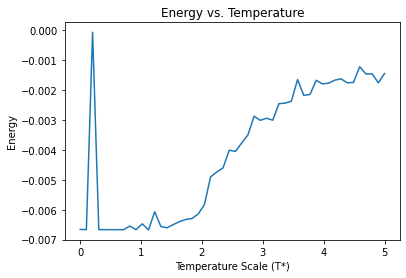

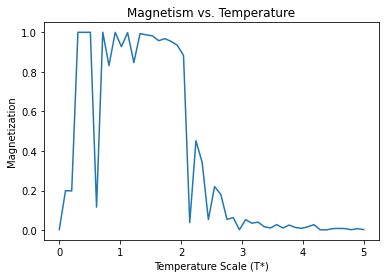

In [14]:
plt.title("Energy vs. Temperature") 
plt.xlabel("Temperature Scale (T*)"); 
plt.ylabel("Energy"); 
plt.plot(T, E) 
plt.show()

plt.title("Magnetism vs. Temperature")  
plt.xlabel("Temperature Scale (T*)"); 
plt.ylabel("Magnetization"); 
plt.plot(T, abs(M))
plt.show()